# Target variable definition

At this point, let's think what actually do we want to treat as our target variable
1. We will start not by a classification task, but the regression one, with general_drug_usage index as our target
2. Next, we will have a classical binary problem - recent drug user (=<1 year) or not.
3. At the end, the same task as in the 3rd point but with adding other drugs to independent variables group

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

In [5]:
# read the data

X = pd.read_csv('Data/X.csv')
y = pd.read_csv('Data/y.csv')
y_binary = pd.read_csv('Data/y_binary.csv')
y_decoded = pd.read_csv('Data/y_decoded.csv')

# Problem 1. Regression - general_drug_index as target

## Data

In [6]:
X.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


In [7]:
y_1 = y_decoded['general_drug_usage']
y_1

0       22
1       43
2       20
3       24
4       27
        ..
1880    29
1881    40
1882    58
1883    38
1884    48
Name: general_drug_usage, Length: 1885, dtype: int64

<Axes: >

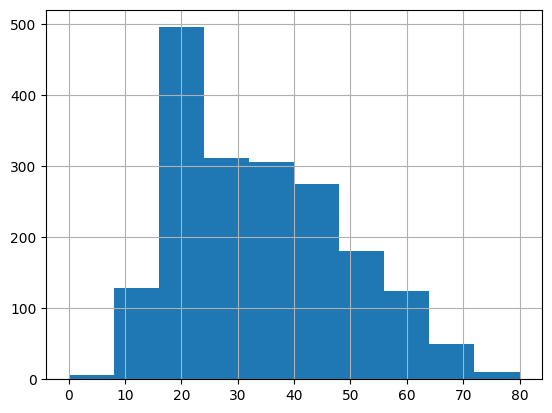

In [8]:
y_decoded['general_drug_usage'].hist()

## Algo 1. Linear regression

In [10]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_1,
    test_size=0.2,
    random_state=42
)

In [13]:
# Define the algorithm
lin_reg = LinearRegression()

# Train regression with 5-fold cross validation
scores = cross_val_score(lin_reg, X_train, y_train,
scoring="neg_mean_squared_error", cv=5)

rmse_scores = np.sqrt(-scores)

print(rmse_scores)
print(rmse_scores.mean())


[10.92117549 11.23507723  9.73106139 11.36978976 11.08213804]
10.867848383042872


On average, predictions are off by ±11 units

That’s roughly:

~14% of the full range (80)

~20–30% of the typical values (30–40

## Algo 2. Single Regression Tree

In [15]:
# Define the model
tree = DecisionTreeRegressor(
    max_depth=5,      # control complexity
    random_state=42
)

# cross validation on the training set
scores = cross_val_score(
    tree,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=5
)

rmse_scores = np.sqrt(-scores)

# Summarize performace
print("RMSE per fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())



RMSE per fold: [12.09662686 11.85265864 10.62408887 11.97360749 11.98508075]
Mean RMSE: 11.706412520348836
Std RMSE: 0.5466495741950388


## Algo 3. Random forest with OOB

In [16]:
rf = RandomForestRegressor(
    n_estimators=500,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=42)

In [17]:
oob_pred = rf.oob_prediction_
rmse = root_mean_squared_error(y_train, oob_pred)
rmse

10.977186094517611

# Problem 2. Classification: recent drug user (less or equal than 1 year?)

## Data

In [39]:
X.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


In [18]:
y_binary
y_drugs = y_binary.drop(columns=['semer'])
y_drugs.head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


## Algo 1. SDG binary clasifier

In [22]:
# In the following code, we recieved the warning message UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. 
# Use `zero_division` parameter to control this behavior

# It highlights the issue if classes' imbalance. Certain fold in cross valdiation
# had 0 for Precision. The presented precision in the output table is the averaged one from 5 folds

In [23]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# This will ignore only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip drugs with almost no users to prevent crashes
    if y.sum() < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    sgd = SGDClassifier(
        loss="log_loss",
        max_iter=5000,
        tol=1e-4,
        random_state=42,
        class_weight="balanced"
    )

    scoring = {
        "acc": "accuracy",
        "bal_acc": "balanced_accuracy",
        "precision": "precision", 
        "recall": "recall",
        "f1": "f1" 
    }

    # Train
    cv = cross_validate(sgd, X_train, y_train, scoring=scoring, cv=skf)
    base = cross_validate(DummyClassifier(strategy="most_frequent"),
                          X_train, y_train, scoring=scoring, cv=skf)

    # Output Row
    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")

Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5596   | 0.6262   | 0.9418
amphet       | 0.7686   | 0.6905   | 0.6700   | 0.4131
amyl         | 0.9297   | 0.6312   | 0.6697   | 0.1171
benzos       | 0.7162   | 0.6719   | 0.7291   | 0.4292
caff         | 0.9675   | 0.5996   | 0.5237   | 0.9788
cannabis     | 0.5298   | 0.7961   | 0.7797   | 0.8255
choc         | 0.9761   | 0.5814   | 0.6843   | 0.9813
coke         | 0.7785   | 0.6462   | 0.6594   | 0.3395
crack        | 0.9582   | 0.7165   | 0.6974   | 0.1078
ecstasy      | 0.7255   | 0.7157   | 0.6882   | 0.5067
heroin       | 0.9377   | 0.6197   | 0.5526   | 0.1285
ketamine     | 0.8899   | 0.6699   | 0.6930   | 0.1994
legalh       | 0.7009   | 0.7035   | 0.7540   | 0.5073
lsd          | 0.7984   | 0.7910   | 0.7730   | 0.5081
meth         | 0.8302   | 0.7299   | 0.7969   | 0.3345
mushrooms    | 0.7699   | 0.7810   | 0.8214   | 0.4

Same job but with hyperparameters tunning

In [36]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning

# Ignore undefined precision/recall warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip drugs with almost no users
    if y.sum() < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        "acc": "accuracy",
        "bal_acc": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1"
    }

    # -------------------------
    # Baseline (Dummy)
    # -------------------------
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # -------------------------
    # SGD + hyperparameter tuning
    # -------------------------
    sgd = SGDClassifier(
        loss="log_loss",
        random_state=42,
        class_weight="balanced"
    )

    param_grid = {
        "alpha": [1e-5, 1e-4, 1e-3],
        "penalty": ["l2", "l1", "elasticnet"],
        "l1_ratio": [0.15, 0.5, 0.85],   # used only for elasticnet
        "max_iter": [2000, 5000],
        "tol": [1e-4, 1e-3]
    }

    grid = GridSearchCV(
        estimator=sgd,
        param_grid=param_grid,
        scoring="balanced_accuracy",  # selection criterion
        cv=skf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_sgd = grid.best_estimator_

    # -------------------------
    # CV evaluation of BEST SGD
    # -------------------------
    cv = cross_validate(
        best_sgd,
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # -------------------------
    # Output row (same format)
    # -------------------------
    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6341   | 0.6462   | 0.9576
amphet       | 0.7686   | 0.7519   | 0.7739   | 0.4658
amyl         | 0.9297   | 0.6803   | 0.6403   | 0.1492
benzos       | 0.7162   | 0.7178   | 0.7338   | 0.4942
caff         | 0.9675   | 0.6340   | 0.5902   | 0.9824
cannabis     | 0.5298   | 0.8157   | 0.8022   | 0.8423
choc         | 0.9761   | 0.5881   | 0.5368   | 0.9835
coke         | 0.7785   | 0.7069   | 0.7127   | 0.4051
crack        | 0.9582   | 0.7527   | 0.8064   | 0.1048
ecstasy      | 0.7255   | 0.7501   | 0.7826   | 0.5130
heroin       | 0.9377   | 0.7392   | 0.7649   | 0.1513
ketamine     | 0.8899   | 0.7159   | 0.7709   | 0.2201
legalh       | 0.7009   | 0.7748   | 0.7871   | 0.5874
lsd          | 0.7984   | 0.8056   | 0.8355   | 0.4858
meth         | 0.8302   | 0.7381   | 0.7774   | 0.3484
mushrooms    | 0.7699   | 0.8068   | 0.8590   | 0.5

## Algo 2. Random Forest with OOB

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare positives (also avoids RF/OOB edge cases)
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    rf = RandomForestClassifier(
        n_estimators=500,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample",
        # optional knobs:
        # max_features="sqrt",
        # min_samples_leaf=2,
    )

    rf.fit(X_train, y_train)

    # ---- OOB predictions (only where OOB proba exists) ----
    oob_proba = rf.oob_decision_function_  # shape: (n_train, n_classes)
    valid = ~np.isnan(oob_proba).any(axis=1)

    # For binary classification, sklearn orders classes as rf.classes_
    # We want predicted class labels.
    oob_pred = rf.classes_[np.argmax(oob_proba[valid], axis=1)]
    y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

    # ---- Baseline (Dummy) on train (single fit) ----
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_train)
    base_acc = accuracy_score(y_train, base_pred)

    # ---- Metrics on OOB ----
    bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)
    rec = recall_score(y_oob_true, oob_pred, zero_division=0)
    prec = precision_score(y_oob_true, oob_pred, zero_division=0)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{bal_acc:.4f}   | "
          f"{rec:.4f}   | "
          f"{prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5000   | 1.0000   | 0.9277
amphet       | 0.7686   | 0.6151   | 0.3009   | 0.5615
amyl         | 0.9297   | 0.4996   | 0.0000   | 0.0000
benzos       | 0.7162   | 0.6068   | 0.3107   | 0.5588
caff         | 0.9675   | 0.5000   | 1.0000   | 0.9675
cannabis     | 0.5298   | 0.8151   | 0.8348   | 0.8214
choc         | 0.9761   | 0.5000   | 1.0000   | 0.9761
coke         | 0.7785   | 0.5442   | 0.1377   | 0.4423
crack        | 0.9582   | 0.5000   | 0.0000   | 0.0000
ecstasy      | 0.7255   | 0.6428   | 0.3961   | 0.5754
heroin       | 0.9377   | 0.5050   | 0.0106   | 0.5000
ketamine     | 0.8899   | 0.5087   | 0.0181   | 0.7500
legalh       | 0.7009   | 0.6978   | 0.5100   | 0.6553
lsd          | 0.7984   | 0.6699   | 0.4079   | 0.6019
meth         | 0.8302   | 0.5785   | 0.1914   | 0.5326
mushrooms    | 0.7699   | 0.6800   | 0.4496   | 0.6

Same job but with hyperparameter tunning

In [37]:
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

# -----------------------------
# Hyperparameter grid (modest)
# -----------------------------
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [None, 8, 15],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

keys = list(param_grid.keys())
param_combinations = list(itertools.product(*[param_grid[k] for k in keys]))

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare positives / negatives
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # -----------------------------
    # Baseline (Dummy)
    # -----------------------------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_train)
    base_acc = accuracy_score(y_train, base_pred)

    # -----------------------------
    # RF + OOB hyperparameter tuning
    # -----------------------------
    best_rf = None
    best_oob_bal_acc = -np.inf

    for values in param_combinations:
        params = dict(zip(keys, values))

        rf = RandomForestClassifier(
            **params,
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=42,
            class_weight="balanced_subsample",
        )

        rf.fit(X_train, y_train)

        # ---- OOB predictions ----
        oob_proba = rf.oob_decision_function_
        valid = ~np.isnan(oob_proba).any(axis=1)
        if valid.sum() == 0:
            continue

        oob_pred = rf.classes_[np.argmax(oob_proba[valid], axis=1)]
        y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

        oob_bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)

        if oob_bal_acc > best_oob_bal_acc:
            best_oob_bal_acc = oob_bal_acc
            best_rf = rf

    # -----------------------------
    # Final OOB metrics (best RF)
    # -----------------------------
    oob_proba = best_rf.oob_decision_function_
    valid = ~np.isnan(oob_proba).any(axis=1)

    oob_pred = best_rf.classes_[np.argmax(oob_proba[valid], axis=1)]
    y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

    bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)
    rec = recall_score(y_oob_true, oob_pred, zero_division=0)
    prec = precision_score(y_oob_true, oob_pred, zero_division=0)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{bal_acc:.4f}   | "
          f"{rec:.4f}   | "
          f"{prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5492   | 0.9700   | 0.9346
amphet       | 0.7686   | 0.7420   | 0.6963   | 0.4969
amyl         | 0.9297   | 0.5758   | 0.2358   | 0.1748
benzos       | 0.7162   | 0.6999   | 0.6379   | 0.5151
caff         | 0.9675   | 0.5102   | 1.0000   | 0.9681
cannabis     | 0.5298   | 0.8220   | 0.8260   | 0.8365
choc         | 0.9761   | 0.5000   | 1.0000   | 0.9761
coke         | 0.7785   | 0.6796   | 0.5569   | 0.4450
crack        | 0.9582   | 0.6107   | 0.2857   | 0.1622
ecstasy      | 0.7255   | 0.7446   | 0.7077   | 0.5508
heroin       | 0.9377   | 0.6224   | 0.3191   | 0.2222
ketamine     | 0.8899   | 0.6329   | 0.4096   | 0.2605
legalh       | 0.7009   | 0.7537   | 0.6918   | 0.6154
lsd          | 0.7984   | 0.7895   | 0.7401   | 0.5370
meth         | 0.8302   | 0.7347   | 0.6211   | 0.4556
mushrooms    | 0.7699   | 0.7899   | 0.7522   | 0.5

## Algo 3. Support Vecotr Machine

In [25]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

for drug in y_drugs.columns:
    y = y_drugs[drug]

    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=20000
    )

    cv = cross_validate(svm, X_train, y_train, scoring=scoring, cv=skf)

    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6281   | 0.6784   | 0.9539
amphet       | 0.7686   | 0.7498   | 0.7766   | 0.4596
amyl         | 0.9297   | 0.6937   | 0.7169   | 0.1418
benzos       | 0.7162   | 0.7141   | 0.7198   | 0.4953
caff         | 0.9675   | 0.5923   | 0.6758   | 0.9763
cannabis     | 0.5298   | 0.8152   | 0.7784   | 0.8558
choc         | 0.9761   | 0.5923   | 0.6488   | 0.9830
coke         | 0.7785   | 0.7154   | 0.7333   | 0.4082
crack        | 0.9582   | 0.7240   | 0.7282   | 0.1020
ecstasy      | 0.7255   | 0.7457   | 0.7609   | 0.5179
heroin       | 0.9377   | 0.7591   | 0.8082   | 0.1566
ketamine     | 0.8899   | 0.7131   | 0.7592   | 0.2201
legalh       | 0.7009   | 0.7649   | 0.7805   | 0.5721
lsd          | 0.7984   | 0.8076   | 0.8420   | 0.4849
meth         | 0.8302   | 0.7288   | 0.7578   | 0.3404
mushrooms    | 0.7699   | 0.8008   | 0.8272   | 0.5

Same job but with hyperparameters tunning

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# --- make precision/recall safe for rare positives (no warnings, no NaNs) ---
scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
}

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9} | Best params")
print("-" * 105)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best hyperparameters per drug (so you can reuse for test set later)
best_params_svm = {}

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare positives / negatives
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---- Baseline (Dummy) ----
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---- Linear SVM ----
    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=20000
    )

    # Hyperparameter grid (modest + standard)
    # C controls regularization strength (bigger C = less regularization)
    param_grid = {
        "C": [0.01, 0.1, 1, 10],
        "loss": ["hinge", "squared_hinge"],
    }

    # NOTE: penalty="l1" only works with loss="squared_hinge" and dual=False.
    # To keep things simple and robust, we tune only loss and C (very common).
    # If you want L1 feature selection later, I can add a second grid safely.

    grid = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        scoring="balanced_accuracy",   # choose best by Bal Acc
        cv=skf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_svm = grid.best_estimator_
    best_params_svm[drug] = grid.best_params_

    # ---- CV metrics for the BEST hyperparameters ----
    cv = cross_validate(
        best_svm,
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---- Print row (same metrics + params) ----
    params_str = f"C={best_params_svm[drug]['C']}, loss={best_params_svm[drug]['loss']}"
    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}   | "
          f"{params_str}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision | Best params
---------------------------------------------------------------------------------------------------------
alcohol      | 0.9277   | 0.6281   | 0.6784   | 0.9539   | C=1, loss=squared_hinge
amphet       | 0.7686   | 0.7498   | 0.7766   | 0.4596   | C=1, loss=squared_hinge


c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


amyl         | 0.9297   | 0.6985   | 0.7450   | 0.1405   | C=1, loss=hinge
benzos       | 0.7162   | 0.7141   | 0.7198   | 0.4953   | C=1, loss=squared_hinge
caff         | 0.9675   | 0.6232   | 0.5709   | 0.9814   | C=0.01, loss=hinge
cannabis     | 0.5298   | 0.8152   | 0.7772   | 0.8571   | C=0.1, loss=squared_hinge
choc         | 0.9761   | 0.6399   | 0.6584   | 0.9861   | C=0.01, loss=hinge
coke         | 0.7785   | 0.7213   | 0.7722   | 0.3996   | C=0.01, loss=hinge
crack        | 0.9582   | 0.7348   | 0.7603   | 0.1028   | C=0.01, loss=squared_hinge
ecstasy      | 0.7255   | 0.7497   | 0.7947   | 0.5060   | C=0.01, loss=hinge


c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


heroin       | 0.9377   | 0.7652   | 0.8620   | 0.1471   | C=1, loss=hinge
ketamine     | 0.8899   | 0.7235   | 0.8316   | 0.2109   | C=0.01, loss=hinge
legalh       | 0.7009   | 0.7681   | 0.8049   | 0.5628   | C=0.01, loss=hinge
lsd          | 0.7984   | 0.8076   | 0.8420   | 0.4849   | C=0.1, loss=squared_hinge
meth         | 0.8302   | 0.7296   | 0.7578   | 0.3417   | C=0.1, loss=squared_hinge


c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

mushrooms    | 0.7699   | 0.8035   | 0.8386   | 0.5201   | C=10, loss=hinge
nicotine     | 0.5623   | 0.7218   | 0.6769   | 0.7897   | C=0.01, loss=hinge
vsa          | 0.9496   | 0.7145   | 0.7600   | 0.1081   | C=0.1, loss=hinge


## SHAP for the best model for Problem 2: SVM

c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: Futu

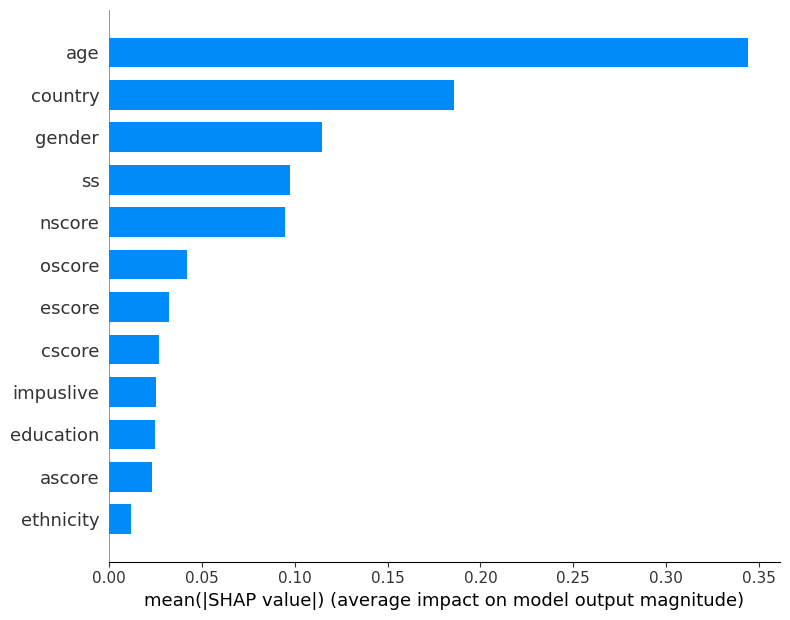


Top 20 features by mean(|SHAP|) across CV training folds:
age                       0.344189
country                   0.185869
gender                    0.114940
ss                        0.097540
nscore                    0.094661
oscore                    0.042156
escore                    0.032108
cscore                    0.026924
impuslive                 0.025152
education                 0.024602
ascore                    0.023033
ethnicity                 0.011822


In [26]:
# =========================
# SHAP on CV TRAINING FOLDS ONLY (for your X-only LinearSVC setup)
# =========================
import shap
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# Assumes these exist from your loop for the CURRENT drug:
# X_train (DataFrame), y_train (Series), svm (LinearSVC)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
feature_names = X_train.columns  # requires X_train to be a pandas DataFrame

for fold, (train_idx, _) in enumerate(skf.split(X_train, y_train)):
    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]

    # Fit a fresh model on this fold's training subset
    svm_fold = clone(svm)
    svm_fold.fit(X_tr, y_tr)

    # Background set for SHAP (sample for speed)
    background = shap.sample(X_tr, 200, random_state=42) if X_tr.shape[0] > 200 else X_tr

    # LinearExplainer explains LinearSVC decision_function (margin)
    explainer = shap.LinearExplainer(
        svm_fold,
        background,
        feature_perturbation="interventional"
    )

    # Compute SHAP values on TRAINING fold only (no test set, no val set)
    shap_vals = explainer.shap_values(X_tr)

    all_shap_values.append(shap_vals)

# Stack all folds together: (sum_rows_over_folds, n_features)
shap_values_cv = np.vstack(all_shap_values)

# Global importance bar plot (no X needed -> avoids index problems)
shap.summary_plot(
    shap_values_cv,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# Optional: print top features
mean_abs_shap = np.abs(shap_values_cv).mean(axis=0)
order = np.argsort(-mean_abs_shap)

print("\nTop 20 features by mean(|SHAP|) across CV training folds:")
for j in order[:20]:
    print(f"{feature_names[j]:<25} {mean_abs_shap[j]:.6f}")


# Problem 3. One drug as target and others included in Xs

## Data

In [40]:
X.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


In [41]:
y_drugs.head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Let's concatenate X and y for a while
df_3 = pd.concat([X, y_drugs], axis=1)
df_3.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,1,0,0,0,0,1,0,1,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,0,0,0,0,0,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,0,0,0


## Algo 1. SGD binary classfier

In [30]:
print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    sgd = SGDClassifier(
        loss="log_loss",
        max_iter=5000,
        tol=1e-4,
        random_state=42,
        class_weight="balanced"
    )

    scoring = {
        "acc": "accuracy",
        "bal_acc": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
    }

    # SGD CV
    cv = cross_validate(sgd, X_train, y_train, scoring=scoring, cv=skf)

    # Baseline CV
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5913   | 0.6960   | 0.9483
amphet       | 0.7686   | 0.7971   | 0.7936   | 0.5590
amyl         | 0.9297   | 0.6767   | 0.6506   | 0.1429
benzos       | 0.7162   | 0.7361   | 0.7574   | 0.5247
caff         | 0.9675   | 0.5784   | 0.5634   | 0.9754
cannabis     | 0.5298   | 0.8455   | 0.8322   | 0.8753
choc         | 0.9761   | 0.5422   | 0.6094   | 0.9800
coke         | 0.7785   | 0.7738   | 0.7085   | 0.6017
crack        | 0.9582   | 0.7884   | 0.7000   | 0.2048
ecstasy      | 0.7255   | 0.8228   | 0.8722   | 0.6084
heroin       | 0.9377   | 0.7987   | 0.7842   | 0.2194
ketamine     | 0.8899   | 0.7741   | 0.6695   | 0.4286
legalh       | 0.7009   | 0.7957   | 0.7760   | 0.6505
lsd          | 0.7984   | 0.8183   | 0.7496   | 0.6514
meth         | 0.8302   | 0.7455   | 0.7498   | 0.4103
mushrooms    | 0.7699   | 0.8272   | 0.8587   | 0.5

After hyperparameters tunning

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score

# Optional but recommended: avoid precision/recall warnings for rare positives
scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
}

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

# Store best hyperparameters per drug so you can reuse later
best_params_sgd_p3 = {}

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Base estimator (we'll tune key hyperparameters)
    sgd = SGDClassifier(
        loss="log_loss",
        random_state=42,
        class_weight="balanced"
    )

    # Hyperparameter grid (modest but meaningful)
    param_grid = {
        "alpha": [1e-5, 1e-4, 1e-3],
        "penalty": ["l2", "l1", "elasticnet"],
        "l1_ratio": [0.15, 0.5, 0.85],   # only used when penalty="elasticnet"
        "max_iter": [2000, 5000],
        "tol": [1e-4, 1e-3],
    }

    # 1) Tune on training only (select by balanced accuracy)
    grid = GridSearchCV(
        estimator=sgd,
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=skf,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_sgd = grid.best_estimator_
    best_params_sgd_p3[drug] = grid.best_params_   # stored, but NOT printed

    # 2) Evaluate best model with CV to produce the same style table
    cv = cross_validate(best_sgd, X_train, y_train, scoring=scoring, cv=skf)

    # Baseline CV
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6653   | 0.5955   | 0.9675
amphet       | 0.7686   | 0.8179   | 0.8481   | 0.5471
amyl         | 0.9297   | 0.7384   | 0.7165   | 0.1907
benzos       | 0.7162   | 0.7699   | 0.7221   | 0.6113
caff         | 0.9675   | 0.6546   | 0.6559   | 0.9828
cannabis     | 0.5298   | 0.8623   | 0.8248   | 0.9032
choc         | 0.9761   | 0.6081   | 0.7234   | 0.9831
coke         | 0.7785   | 0.8454   | 0.8713   | 0.5791
crack        | 0.9582   | 0.8467   | 0.8705   | 0.1796
ecstasy      | 0.7255   | 0.8457   | 0.8551   | 0.6663
heroin       | 0.9377   | 0.8324   | 0.8070   | 0.2767
ketamine     | 0.8899   | 0.8439   | 0.8613   | 0.3828
legalh       | 0.7009   | 0.8140   | 0.8247   | 0.6434
lsd          | 0.7984   | 0.8576   | 0.8546   | 0.6196
meth         | 0.8302   | 0.7898   | 0.7968   | 0.4363
mushrooms    | 0.7699   | 0.8501   | 0.8586   | 0.6

## Algo 2. Random Forest wit OOB

In [32]:
print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------------- Random Forest (OOB) ----------------
    rf = RandomForestClassifier(
        n_estimators=500,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample",
    )

    rf.fit(X_train, y_train)

    # ---- OOB predictions ----
    oob_proba = rf.oob_decision_function_
    valid = ~np.isnan(oob_proba).any(axis=1)

    oob_pred = rf.classes_[np.argmax(oob_proba[valid], axis=1)]
    y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

    rf_bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)
    rf_rec = recall_score(y_oob_true, oob_pred, zero_division=0)
    rf_prec = precision_score(y_oob_true, oob_pred, zero_division=0)

    # ---------------- Baseline (train, single fit) ----------------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_train)
    base_acc = accuracy_score(y_train, base_pred)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{rf_bal_acc:.4f}   | "
          f"{rf_rec:.4f}   | "
          f"{rf_prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5000   | 1.0000   | 0.9277
amphet       | 0.7686   | 0.7252   | 0.5186   | 0.6962
amyl         | 0.9297   | 0.5084   | 0.0189   | 0.4000
benzos       | 0.7162   | 0.7155   | 0.5070   | 0.7258
caff         | 0.9675   | 0.5000   | 1.0000   | 0.9675
cannabis     | 0.5298   | 0.8692   | 0.8836   | 0.8727
choc         | 0.9761   | 0.5000   | 1.0000   | 0.9761
coke         | 0.7785   | 0.7384   | 0.5389   | 0.7115
crack        | 0.9582   | 0.5072   | 0.0159   | 0.3333
ecstasy      | 0.7255   | 0.8119   | 0.7126   | 0.7526
heroin       | 0.9377   | 0.5238   | 0.0532   | 0.3846
ketamine     | 0.8899   | 0.6040   | 0.2229   | 0.6491
legalh       | 0.7009   | 0.7831   | 0.6807   | 0.7173
lsd          | 0.7984   | 0.7797   | 0.6184   | 0.7259
meth         | 0.8302   | 0.6719   | 0.3750   | 0.7111
mushrooms    | 0.7699   | 0.7949   | 0.6571   | 0.7

Hyperparameters tunning

In [44]:
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

# Store best hyperparameters per drug
best_params_rf_p3 = {}

# Modest hyperparameter grid (adjust for runtime)
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [None, 8, 15],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

keys = list(param_grid.keys())
param_combinations = list(itertools.product(*[param_grid[k] for k in keys]))

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------------- Baseline (train, single fit) ----------------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_train)
    base_acc = accuracy_score(y_train, base_pred)

    # ---------------- RF + OOB hyperparameter tuning ----------------
    best_rf = None
    best_oob_bal_acc = -np.inf
    best_params = None

    for values in param_combinations:
        params = dict(zip(keys, values))

        rf = RandomForestClassifier(
            **params,
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=42,
            class_weight="balanced_subsample",
        )

        rf.fit(X_train, y_train)

        # ---- OOB predictions ----
        oob_proba = rf.oob_decision_function_
        valid = ~np.isnan(oob_proba).any(axis=1)

        # if OOB proba is unavailable for all rows (rare edge case)
        if valid.sum() == 0:
            continue

        oob_pred = rf.classes_[np.argmax(oob_proba[valid], axis=1)]
        y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

        oob_bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)

        if oob_bal_acc > best_oob_bal_acc:
            best_oob_bal_acc = oob_bal_acc
            best_rf = rf
            best_params = params

    # Store best params (do not print)
    best_params_rf_p3[drug] = best_params

    # ---------------- Final OOB metrics for best RF ----------------
    oob_proba = best_rf.oob_decision_function_
    valid = ~np.isnan(oob_proba).any(axis=1)

    oob_pred = best_rf.classes_[np.argmax(oob_proba[valid], axis=1)]
    y_oob_true = y_train.iloc[valid] if hasattr(y_train, "iloc") else y_train[valid]

    rf_bal_acc = balanced_accuracy_score(y_oob_true, oob_pred)
    rf_rec = recall_score(y_oob_true, oob_pred, zero_division=0)
    rf_prec = precision_score(y_oob_true, oob_pred, zero_division=0)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{rf_bal_acc:.4f}   | "
          f"{rf_rec:.4f}   | "
          f"{rf_prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.5956   | 0.9342   | 0.9416
amphet       | 0.7686   | 0.8171   | 0.8138   | 0.5772
amyl         | 0.9297   | 0.6609   | 0.3774   | 0.3390
benzos       | 0.7162   | 0.7684   | 0.6729   | 0.6621
caff         | 0.9675   | 0.5162   | 0.9712   | 0.9686
cannabis     | 0.5298   | 0.8717   | 0.8874   | 0.8742
choc         | 0.9761   | 0.5000   | 1.0000   | 0.9761
coke         | 0.7785   | 0.8343   | 0.8024   | 0.6306
crack        | 0.9582   | 0.6887   | 0.4127   | 0.3377
ecstasy      | 0.7255   | 0.8574   | 0.8647   | 0.6858
heroin       | 0.9377   | 0.7579   | 0.5638   | 0.4380
ketamine     | 0.8899   | 0.8018   | 0.7108   | 0.4504
legalh       | 0.7009   | 0.8231   | 0.8514   | 0.6389
lsd          | 0.7984   | 0.8728   | 0.8651   | 0.6462
meth         | 0.8302   | 0.7908   | 0.7070   | 0.5355
mushrooms    | 0.7699   | 0.8660   | 0.8646   | 0.6

## Algo 3. Support Vector Machine

In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=20000
    )

    scoring = {
        "acc": "accuracy",
        "bal_acc": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
    }

    # SVM CV
    cv = cross_validate(svm, X_train, y_train, scoring=scoring, cv=skf)

    # Baseline CV
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6813   | 0.6919   | 0.9644
amphet       | 0.7686   | 0.8214   | 0.8395   | 0.5637
amyl         | 0.9297   | 0.7478   | 0.7082   | 0.2014
benzos       | 0.7162   | 0.7626   | 0.7057   | 0.6082
caff         | 0.9675   | 0.6128   | 0.6922   | 0.9781
cannabis     | 0.5298   | 0.8558   | 0.8273   | 0.8901
choc         | 0.9761   | 0.6009   | 0.7555   | 0.9824
coke         | 0.7785   | 0.8420   | 0.8502   | 0.5951
crack        | 0.9582   | 0.8149   | 0.7474   | 0.2162
ecstasy      | 0.7255   | 0.8419   | 0.8382   | 0.6733
heroin       | 0.9377   | 0.8348   | 0.8181   | 0.2712
ketamine     | 0.8899   | 0.8496   | 0.8676   | 0.3893
legalh       | 0.7009   | 0.8150   | 0.8314   | 0.6416
lsd          | 0.7984   | 0.8605   | 0.8714   | 0.5955
meth         | 0.8302   | 0.7939   | 0.7812   | 0.4545
mushrooms    | 0.7699   | 0.8548   | 0.8759   | 0.6

Hyperparametrs tunning

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score
import warnings
from sklearn.exceptions import ConvergenceWarning

# Optional: silence convergence warnings (after we address the cause)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

# Safe scoring (avoids undefined precision/recall)
scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best hyperparameters per drug
best_params_svm_p3 = {}

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    df = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------------- Baseline (CV) ----------------
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---------------- Linear SVM ----------------
    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=50000,   # ↑ increased to reduce convergence issues
        tol=1e-3          # slightly relaxed tolerance (helps stability)
    )

    # Hyperparameter grid (focused & safe)
    param_grid = {
        "C": [0.01, 0.1, 1, 10],
        "loss": ["hinge", "squared_hinge"],
    }

    # 1) Tune on training set using CV
    grid = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=skf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_svm = grid.best_estimator_
    best_params_svm_p3[drug] = grid.best_params_   # stored, not printed

    # 2) CV evaluation of BEST SVM (same table format)
    cv = cross_validate(
        best_svm,
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6813   | 0.6919   | 0.9644
amphet       | 0.7686   | 0.8220   | 0.8424   | 0.5622
amyl         | 0.9297   | 0.7676   | 0.7550   | 0.2062
benzos       | 0.7162   | 0.7689   | 0.7267   | 0.6044
caff         | 0.9675   | 0.6357   | 0.6580   | 0.9810
cannabis     | 0.5298   | 0.8580   | 0.8260   | 0.8948
choc         | 0.9761   | 0.6085   | 0.7385   | 0.9830
coke         | 0.7785   | 0.8442   | 0.8562   | 0.5936
crack        | 0.9582   | 0.8475   | 0.8410   | 0.2010
ecstasy      | 0.7255   | 0.8489   | 0.8551   | 0.6743
heroin       | 0.9377   | 0.8468   | 0.8825   | 0.2385
ketamine     | 0.8899   | 0.8592   | 0.9039   | 0.3765
legalh       | 0.7009   | 0.8207   | 0.8447   | 0.6436
lsd          | 0.7984   | 0.8683   | 0.8977   | 0.5851
meth         | 0.8302   | 0.8010   | 0.7968   | 0.4572
mushrooms    | 0.7699   | 0.8608   | 0.8991   | 0.6

## SHAP for the best model for Problem 3: SVM

c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\e

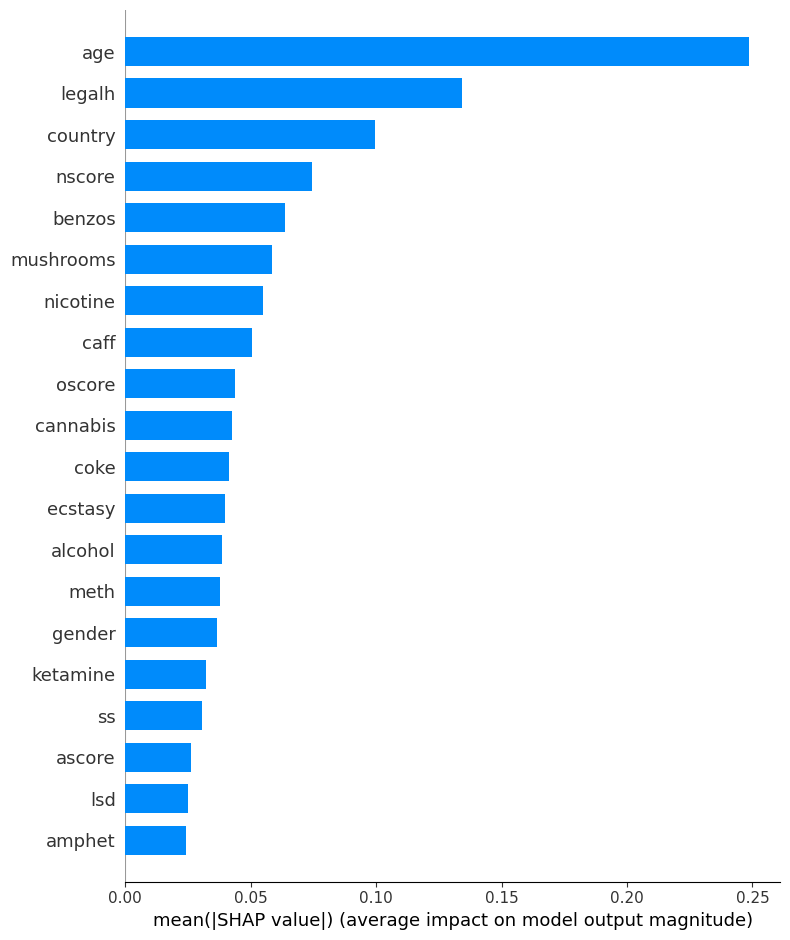


Top 20 features by mean(|SHAP|) across CV training folds:
age                  0.248567
legalh               0.134165
country              0.099511
nscore               0.074222
benzos               0.063592
mushrooms            0.058598
nicotine             0.054992
caff                 0.050655
oscore               0.043523
cannabis             0.042465
coke                 0.041176
ecstasy              0.039920
alcohol              0.038474
meth                 0.037604
gender               0.036390
ketamine             0.032332
ss                   0.030700
ascore               0.025987
lsd                  0.024990
amphet               0.024344


In [34]:
# =========================
# SHAP on CV TRAINING FOLDS ONLY (LinearSVC)
# =========================
import shap
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# Assumes these already exist from your code:
# X_train (DataFrame), y_train (Series), svm (LinearSVC), skf or StratifiedKFold settings

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_shap_values = []
all_feature_names = X_train.columns

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]

    # Fit a fresh model on THIS fold's training subset
    svm_fold = clone(svm)
    svm_fold.fit(X_tr, y_tr)

    # Background for SHAP (sample for speed)
    background = shap.sample(X_tr, 200, random_state=42) if X_tr.shape[0] > 200 else X_tr

    # SHAP explainer for linear SVM (explains decision_function margin)
    explainer = shap.LinearExplainer(
        svm_fold,
        background,
        feature_perturbation="interventional"
    )

    # Compute SHAP values on TRAINING fold only (no test, no val)
    shap_vals = explainer.shap_values(X_tr)

    all_shap_values.append(shap_vals)

# Stack all folds together: shape = (sum_train_rows_over_folds, n_features)
shap_values_cv = np.vstack(all_shap_values)

# Global importance bar plot (does NOT need X, avoids index issues)
shap.summary_plot(
    shap_values_cv,
    feature_names=all_feature_names,
    plot_type="bar",
    show=True
)

# Optional: get a ranked importance table
mean_abs_shap = np.abs(shap_values_cv).mean(axis=0)
shap_importance = (
    np.argsort(-mean_abs_shap)
)

print("\nTop 20 features by mean(|SHAP|) across CV training folds:")
for j in shap_importance[:20]:
    print(f"{all_feature_names[j]:<20} {mean_abs_shap[j]:.6f}")


# Feature engineering

In [46]:
X.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


In [35]:
y_drugs.head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 1. Drop ethnicity column, becase SHAP score for this feature from vladiation sets is low
# 2. Add interaction varaibles such as featured_X["age_gender"] = featured_X['age'] * featured_X['gender'] featured_X["age_country"] = featured_X['age'] * featured_X['country']
# 3. Perform PCA on every personality traits except for ss and nscore


## PCA

In [51]:
from sklearn.decomposition import PCA
import pandas as pd

# Select personality traits
traits = X[['escore', 'oscore', 'ascore', 'cscore', 'impuslive']]

# Fit PCA (EDA only)
pca = PCA()
pca.fit(traits)

# Explained variance table
explained_variance = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": pca.explained_variance_ratio_.cumsum()
})

explained_variance

,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,0.325110,0.325110
1,PC2,0.283941,0.609051
2,PC3,0.167449,0.776499
3,PC4,0.128880,0.905379
4,PC5,0.094621,1.000000


In [52]:
# I will take PC1 and PC2

## Final featured dataset

In [56]:
# Drop ethinicity
X_featured = X.drop(columns=['ethnicity'])

# Add interaction variables
X_featured["age_gender"] = X_featured['age'] * X_featured['gender'] 
X_featured["age_country"] = X_featured['age'] * X_featured['country']

# For PCA dimension reduction of personlaity traits, I wll use PC1 and PC2, which explain together 60% of variance...


In [55]:
y_drugs.head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


Let's run again SVM algorithm only for classification task. Random Forest in general learn more quickly nonlinear relations, so adding interaction varaibles should not have many added value

##  Problem 2

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# --- make precision/recall safe for rare positives (no warnings, no NaNs) ---
scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
}

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9} | Best params")
print("-" * 105)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best hyperparameters per drug (so you can reuse for test set later)
best_params_svm = {}

# -----
# Use your engineered features
# -----
X_used = X_featured

# Traits to PCA -> PC1, PC2 (use your actual column spelling)
pca_traits = ['escore', 'oscore', 'ascore', 'cscore', 'impuslive']

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare positives / negatives
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X_used, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---- Baseline (Dummy) ----
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---- Fold-safe PCA + Linear SVM ----
    preprocessor = ColumnTransformer(
        transformers=[
            ("pca_traits", PCA(n_components=2, random_state=42), pca_traits),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=200000,   # << increased a lot to reduce convergence warnings
        tol=1e-4           # you can try 1e-3 if you want faster / less strict convergence
    )

    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", svm)
    ])

    # Hyperparameter grid (modest + standard)
    param_grid = {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__loss": ["hinge", "squared_hinge"],
    }

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="balanced_accuracy",   # choose best by Bal Acc
        cv=skf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_svm = grid.best_estimator_
    best_params_svm[drug] = grid.best_params_

    # ---- CV metrics for the BEST hyperparameters ----
    cv = cross_validate(
        best_svm,
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---- Print row (same metrics + params) ----
    params_str = f"C={best_params_svm[drug]['clf__C']}, loss={best_params_svm[drug]['clf__loss']}"
    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}   | "
          f"{params_str}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision | Best params
---------------------------------------------------------------------------------------------------------
alcohol      | 0.9277   | 0.6162   | 0.6475   | 0.9524   | C=0.01, loss=hinge
amphet       | 0.7686   | 0.7538   | 0.7967   | 0.4554   | C=0.1, loss=squared_hinge
amyl         | 0.9297   | 0.6857   | 0.7173   | 0.1362   | C=0.01, loss=squared_hinge
benzos       | 0.7162   | 0.7064   | 0.7127   | 0.4859   | C=1, loss=squared_hinge
caff         | 0.9675   | 0.6164   | 0.6395   | 0.9792   | C=0.1, loss=squared_hinge
cannabis     | 0.5298   | 0.8067   | 0.7672   | 0.8494   | C=10, loss=hinge
choc         | 0.9761   | 0.5979   | 0.6957   | 0.9828   | C=0.1, loss=squared_hinge
coke         | 0.7785   | 0.7133   | 0.7783   | 0.3861   | C=0.01, loss=hinge
crack        | 0.9582   | 0.7555   | 0.8564   | 0.0986   | C=0.01, loss=hinge
ecstasy      | 0.7255   | 0.7513   | 0.7778   | 0.5184   | C=0.1, loss=hinge
heroin     

## Problem 3

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Optional: silence convergence warnings (after we address the cause)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

# Safe scoring (avoids undefined precision/recall)
scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best hyperparameters per drug
best_params_svm_p3 = {}

# Traits -> PCA -> PC1/PC2 (use your actual column spelling)
pca_traits = ['escore', 'oscore', 'ascore', 'cscore', 'impuslive']

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    # X = engineered X + other drugs (excluding target)
    other_drugs = y_drugs.drop(columns=[drug])
    df = pd.concat([X_featured, other_drugs], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------------- Baseline (CV) ----------------
    base = cross_validate(
        DummyClassifier(strategy="most_frequent"),
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    # ---------------- Fold-safe PCA + Linear SVM ----------------
    preprocessor = ColumnTransformer(
        transformers=[
            ("pca_traits", PCA(n_components=2, random_state=42), pca_traits),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=200000,   # ↑ more headroom than 50k
        tol=1e-3           # relaxed tolerance helps convergence
    )

    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", svm)
    ])

    # Hyperparameter grid (focused & safe)
    param_grid = {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__loss": ["hinge", "squared_hinge"],
    }

    # 1) Tune on training set using CV (PCA is refit each fold automatically)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=skf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_svm = grid.best_estimator_
    best_params_svm_p3[drug] = grid.best_params_   # stored, not printed

    # 2) CV evaluation of BEST SVM (same table format)
    cv = cross_validate(
        best_svm,
        X_train, y_train,
        scoring=scoring,
        cv=skf
    )

    print(f"{drug:<12} | "
          f"{base['test_acc'].mean():.4f}   | "
          f"{cv['test_bal_acc'].mean():.4f}   | "
          f"{cv['test_recall'].mean():.4f}   | "
          f"{cv['test_precision'].mean():.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9277   | 0.6707   | 0.6712   | 0.9632
amphet       | 0.7686   | 0.8210   | 0.8482   | 0.5554
amyl         | 0.9297   | 0.7560   | 0.7359   | 0.1993
benzos       | 0.7162   | 0.7671   | 0.7267   | 0.5996
caff         | 0.9675   | 0.6321   | 0.6909   | 0.9800
cannabis     | 0.5298   | 0.8547   | 0.8222   | 0.8919
choc         | 0.9761   | 0.5846   | 0.7229   | 0.9817
coke         | 0.7785   | 0.8331   | 0.8323   | 0.5898
crack        | 0.9582   | 0.8367   | 0.8256   | 0.1915
ecstasy      | 0.7255   | 0.8487   | 0.8455   | 0.6845
heroin       | 0.9377   | 0.8482   | 0.8825   | 0.2417
ketamine     | 0.8899   | 0.8587   | 0.9037   | 0.3749
legalh       | 0.7009   | 0.8205   | 0.8359   | 0.6511
lsd          | 0.7984   | 0.8725   | 0.8978   | 0.5978
meth         | 0.8302   | 0.8039   | 0.8202   | 0.4425
mushrooms    | 0.7699   | 0.8649   | 0.8875   | 0.6

## Conclusion 
The performance metrics did not improve significantly after feature engineering

# Running SVM on the test set - classification problems

## Problem 2

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

def strip_pipeline_prefix(params: dict, prefix: str = "clf__") -> dict:
    """
    If params come from a Pipeline grid search, they may be like 'clf__C'.
    This converts them to 'C' so they can be passed to LinearSVC directly.
    If there is no prefix, it returns params unchanged.
    """
    out = {}
    for k, v in params.items():
        if k.startswith(prefix):
            out[k[len(prefix):]] = v
        else:
            out[k] = v
    return out

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # Skip ultra-rare positives / negatives
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    # Reproducible split (same every run with same X/y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ----- Baseline (Dummy) on TEST -----
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_test)
    base_acc = accuracy_score(y_test, base_pred)

    # ----- Best SVM on TEST -----
    if drug not in best_params_svm:
        continue  # safety: only evaluate drugs we tuned

    # Handle both cases:
    # - params stored as {'C': ..., 'loss': ...}
    # - params stored from a Pipeline as {'clf__C': ..., 'clf__loss': ...}
    params = strip_pipeline_prefix(best_params_svm[drug], prefix="clf__")

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=20000,
        **params
    )

    svm.fit(X_train, y_train)
    test_pred = svm.predict(X_test)

    bal_acc = balanced_accuracy_score(y_test, test_pred)
    rec = recall_score(y_test, test_pred, zero_division=0)
    prec = precision_score(y_test, test_pred, zero_division=0)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{bal_acc:.4f}   | "
          f"{rec:.4f}   | "
          f"{prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9284   | 0.5950   | 0.6714   | 0.9476
amphet       | 0.7692   | 0.7615   | 0.7816   | 0.4755
amyl         | 0.9284   | 0.7160   | 0.7778   | 0.1479
benzos       | 0.7162   | 0.7014   | 0.7103   | 0.4780
caff         | 0.9682   | 0.6553   | 0.6438   | 0.9833
cannabis     | 0.5305   | 0.8337   | 0.8200   | 0.8586
choc         | 0.9761   | 0.4873   | 0.6413   | 0.9752
coke         | 0.7798   | 0.6869   | 0.6867   | 0.3826
crack        | 0.9576   | 0.7262   | 0.8125   | 0.0909
ecstasy      | 0.7268   | 0.7552   | 0.7184   | 0.5649
heroin       | 0.9363   | 0.7714   | 0.9167   | 0.1429
ketamine     | 0.8886   | 0.6930   | 0.6905   | 0.2214
legalh       | 0.7003   | 0.8092   | 0.8230   | 0.6327
lsd          | 0.7984   | 0.8411   | 0.8947   | 0.5152
meth         | 0.8302   | 0.7827   | 0.8594   | 0.3741
mushrooms    | 0.7692   | 0.7914   | 0.8621   | 0.4

## Problem 3

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

print(f"{'Drug':<12} | {'Base Acc':<8} | {'Bal Acc':<8} | {'Recall':<8} | {'Precision':<9}")
print("-" * 65)

def strip_pipeline_prefix(params: dict, prefix: str = "clf__") -> dict:
    """
    If params come from a Pipeline grid search, they may be like 'clf__C'.
    This converts them to 'C' so they can be passed to LinearSVC directly.
    If there is no prefix, it returns params unchanged.
    """
    out = {}
    for k, v in params.items():
        out[k[len(prefix):]] = v if k.startswith(prefix) else v
        if not k.startswith(prefix):
            out[k] = v
    # The above would duplicate keys for non-prefixed params; fix cleanly:
    out = { (k[len(prefix):] if k.startswith(prefix) else k): v for k, v in params.items() }
    return out

for drug in y_drugs.columns:
    y = y_drugs[drug]

    # X = original X + other drugs (excluding target)
    Xp3 = df_3.drop(columns=[drug])

    # Skip ultra-rare targets
    if y.sum() < 2 or (y.shape[0] - y.sum()) < 2:
        continue

    # Same split as tuning cell (reproducible)
    X_train, X_test, y_train, y_test = train_test_split(
        Xp3, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------- Baseline (Dummy) on TEST ----------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    base_pred = dummy.predict(X_test)
    base_acc = accuracy_score(y_test, base_pred)

    # ---------- Best SVM on TEST ----------
    if drug not in best_params_svm_p3:
        continue  # safety

    params = strip_pipeline_prefix(best_params_svm_p3[drug], prefix="clf__")

    svm = LinearSVC(
        class_weight="balanced",
        random_state=42,
        max_iter=50000,   # same as your tuning cell
        tol=1e-3,
        **params
    )

    svm.fit(X_train, y_train)
    test_pred = svm.predict(X_test)

    bal_acc = balanced_accuracy_score(y_test, test_pred)
    rec = recall_score(y_test, test_pred, zero_division=0)
    prec = precision_score(y_test, test_pred, zero_division=0)

    print(f"{drug:<12} | "
          f"{base_acc:.4f}   | "
          f"{bal_acc:.4f}   | "
          f"{rec:.4f}   | "
          f"{prec:.4f}")


Drug         | Base Acc | Bal Acc  | Recall   | Precision
-----------------------------------------------------------------
alcohol      | 0.9284   | 0.6150   | 0.7114   | 0.9504
amphet       | 0.7692   | 0.8109   | 0.8391   | 0.5368
amyl         | 0.9284   | 0.8203   | 0.8148   | 0.2651
benzos       | 0.7162   | 0.7534   | 0.7290   | 0.5652
caff         | 0.9682   | 0.5788   | 0.6575   | 0.9756
cannabis     | 0.5305   | 0.8679   | 0.8600   | 0.8866
choc         | 0.9761   | 0.5226   | 0.7120   | 0.9776
coke         | 0.7798   | 0.8623   | 0.8675   | 0.6316
crack        | 0.9576   | 0.8641   | 0.8750   | 0.2090
ecstasy      | 0.7268   | 0.8499   | 0.8641   | 0.6642
heroin       | 0.9363   | 0.8828   | 0.9583   | 0.2527
ketamine     | 0.8886   | 0.8494   | 0.8810   | 0.3776
legalh       | 0.7003   | 0.8370   | 0.8407   | 0.6835
lsd          | 0.7984   | 0.8741   | 0.9211   | 0.5738
meth         | 0.8302   | 0.8117   | 0.8438   | 0.4390
mushrooms    | 0.7692   | 0.8126   | 0.8046   | 0.5